<a href="https://colab.research.google.com/github/s1102498/financial_analysis/blob/master/economia_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisi dati Opencoesione

Esecuzione di analisi della banca dati Opencoesione circa i progetti relativi al ciclo di programmazione 2014/2020 aventi come tema sintetico quello della *Ricerca ed innovazione*.

## Gruppo di lavoro:

* Lanciotti Antonio
* Di Gaetano Anna
* Olivieri Davide
* D'Agostino Lorenzo

### Target: Regione Marche
Andranno individuati i progetti che ricadono nelle aree tematiche della S3 regionale e di Impresa 4.0 (*leggere [README](https://github.com/LorenzoDag/Economia#readme)*)

### Import librerie ed inizializzazione sessione

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz
!tar xf spark-3.1.1-bin-hadoop2.7.tgz
!rm *.tgz
!pip install -q findspark

In [ ]:
!rm -r csv

!wget https://opencoesione.gov.it/it/opendata/localizzazioni.zip
!unzip localizzazioni.zip -d csv && mv csv/localizzazioni*.csv csv/localizzazioni.csv

!wget https://opencoesione.gov.it/it/opendata/progetti.zip
!unzip progetti.zip -d csv && mv csv/progetti*.csv csv/progetti.csv

!wget https://opencoesione.gov.it/it/opendata/soggetti.zip
!unzip soggetti.zip -d csv && mv csv/soggetti*.csv csv/soggetti.csv

!rm *.zip

rm: cannot remove 'csv': No such file or directory
--2021-05-31 17:03:42--  https://opencoesione.gov.it/it/opendata/localizzazioni.zip
Resolving opencoesione.gov.it (opencoesione.gov.it)... 188.166.192.83
Connecting to opencoesione.gov.it (opencoesione.gov.it)|188.166.192.83|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /media/open_data//localizzazioni_20210228.zip [following]
--2021-05-31 17:03:43--  https://opencoesione.gov.it/media/open_data//localizzazioni_20210228.zip
Reusing existing connection to opencoesione.gov.it:443.
HTTP request sent, awaiting response... 200 OK
Length: 23492629 (22M) [application/zip]
Saving to: ‘localizzazioni.zip’

localizzazioni.zip  100%[===================>]  22.40M  14.9MB/s    in 1.5s    

2021-05-31 17:03:44 (14.9 MB/s) - ‘localizzazioni.zip’ saved [23492629/23492629]

Archive:  localizzazioni.zip
  inflating: csv/localizzazioni_20210228.csv  
--2021-05-31 17:03:46--  https://opencoesione.gov.it/it/opendata/progetti

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace # Bisogna sostituire le ',' con '.' nei numeri altrimenti il casting fallisce
from pyspark.sql.types import DoubleType

spark = SparkSession.builder.appName("Economia").getOrCreate()
spark.catalog.clearCache()

### Upload dataset
**Nota**: Cambiare i path

In [ ]:
path_localizzazioni = "csv/localizzazioni.csv"
path_progetti = "csv/progetti.csv"
path_soggetti = "csv/soggetti.csv"

localizzazioni = spark.read.option("delimiter", ";").option("header", True).csv(path_localizzazioni)
localizzazioni.createOrReplaceTempView("localizzazioni") # Rende la tabella visibile a spark (per query)
progetti = spark.read.option("delimiter", ";").option("header", True).csv(path_progetti)
progetti = progetti.withColumn("FINANZ_TOTALE_PUBBLICO", regexp_replace("FINANZ_TOTALE_PUBBLICO", ",", "."))
progetti = progetti.withColumn("FINANZ_TOTALE_PUBBLICO", progetti["FINANZ_TOTALE_PUBBLICO"].cast(DoubleType())).fillna(0, subset=["FINANZ_TOTALE_PUBBLICO"])
progetti.createOrReplaceTempView("progetti")             # Rende la tabella visibile a spark (per query)
soggetti = spark.read.option("delimiter", ";").option("header", True).csv(path_soggetti)
soggetti.createOrReplaceTempView("soggetti")             # Rende la tabella visibile a spark (per query)

### Definizione e consecutiva esecuzione query
Seleziona le colonne descritte nel [README](https://github.com/LorenzoDag/Economia#readme) ed esegue una join on *COD_LOCALE_PROGETTO*

In [ ]:
select_loc = "localizzazioni.COD_LOCALE_PROGETTO, localizzazioni.DEN_REGIONE, localizzazioni.DEN_PROVINCIA, localizzazioni.DEN_COMUNE, localizzazioni.INDIRIZZO_PROG"
select_prog = "progetti.OC_TITOLO_PROGETTO, progetti.OC_SINTESI_PROGETTO, progetti.DESCRIZIONE_GRANDE_PROGETTO, progetti.CUP_DESCR_CATEGORIA, progetti.CUP_DESCR_NATURA,progetti.CUP_DESCR_TIPOLOGIA,progetti.CUP_DESCR_SETTORE,progetti.CUP_DESCR_SOTTOSETTORE,progetti.OC_DATA_INIZIO_PROGETTO,progetti.FINANZ_TOTALE_PUBBLICO"
#select_sogg = "soggetti.COD_ATECO_SOGG, soggetti.SOGG_DESCR_RUOLO, soggetti.OC_CODICE_FISCALE_SOGG, soggetti.OC_DENOMINAZIONE_SOGG, soggetti.INDIRIZZO_SOGG, soggetti.CAP_SOGG"

where_prog = "progetti.OC_COD_CICLO = 2 AND progetti.OC_COD_TEMA_SINTETICO = 1"
where_loc = "LOWER(localizzazioni.DEN_REGIONE) LIKE '%marche%'"

QUERY = "SELECT " + select_loc + ", " + select_prog + " FROM localizzazioni INNER JOIN progetti ON localizzazioni.COD_LOCALE_PROGETTO = progetti.COD_LOCALE_PROGETTO WHERE " + where_loc + " AND " + where_prog

In [ ]:
result_dataframe = spark.sql(QUERY).dropDuplicates().cache()

# Filtraggio del dataframe
L'obiettivo e' quello di filtrare le righe del dataframe contenenti parole chiave riconducibili a progetti inerenti le dimensioni tematiche descritte nel file [README](https://github.com/LorenzoDag/Economia#readme) ed i progetti di **industria 4.0**

### Definizione funzione filtro
input: 
> * dataframe_name : (String) nome della tabella cachata
> * testo : (String / List of string) testo da filtrare all'interno della tabella

output:
> * None : se testo vuoto
> * dataframe filtrato : (pyspark.sql.dataframe.DataFrame) dataframe contenente le righe che contengono testo

In [ ]:
from functools import reduce
from pyspark.sql import DataFrame

def filterDataframeForKeyword(dataframe, testo=''):
    if not testo: return None
    if not isinstance(dataframe, DataFrame): raise ValueError("dataframe must be a pyspark.sql.DataFrame instance")
    if not isinstance(testo, list):
        testo = testo.lower()
        ret_df = dataframe.where(f"LOWER(DESCRIZIONE_GRANDE_PROGETTO) LIKE '%{testo}%' OR LOWER(OC_TITOLO_PROGETTO) LIKE '%{testo}%' OR LOWER(OC_SINTESI_PROGETTO) LIKE '%{testo}%' OR LOWER(CUP_DESCR_NATURA) LIKE '%{testo}%' OR LOWER(CUP_DESCR_TIPOLOGIA) LIKE '%{testo}%' OR LOWER(CUP_DESCR_SETTORE) LIKE '%{testo}%' OR LOWER(CUP_DESCR_SOTTOSETTORE) LIKE '%{testo}%' OR LOWER(CUP_DESCR_CATEGORIA) LIKE '%{testo}%'")
        #spark.sql(f"DELETE FROM {dataframe_name} WHERE LOWER(DESCRIZIONE_GRANDE_PROGETTO) LIKE '%{testo}%' OR LOWER(OC_TITOLO_PROGETTO) LIKE '%{testo}%' OR LOWER(OC_SINTESI_PROGETTO) LIKE '%{testo}%' OR LOWER(CUP_DESCR_NATURA) LIKE '%{testo}%' OR LOWER(CUP_DESCR_TIPOLOGIA) LIKE '%{testo}%' OR LOWER(CUP_DESCR_SETTORE) LIKE '%{testo}%' OR LOWER(CUP_DESCR_SOTTOSETTORE) LIKE '%{testo}%' OR LOWER(CUP_DESCR_CATEGORIA) LIKE '%{testo}%'")
        return ret_df
    df_list = []
    for word in testo:
        df_list.append(dataframe.where(f"LOWER(DESCRIZIONE_GRANDE_PROGETTO) LIKE '%{word}%' OR LOWER(OC_TITOLO_PROGETTO) LIKE '%{word}%' OR LOWER(OC_SINTESI_PROGETTO) LIKE '%{word}%' OR LOWER(CUP_DESCR_NATURA) LIKE '%{word}%' OR LOWER(CUP_DESCR_TIPOLOGIA) LIKE '%{word}%' OR LOWER(CUP_DESCR_SETTORE) LIKE '%{word}%' OR LOWER(CUP_DESCR_SOTTOSETTORE) LIKE '%{word}%' OR LOWER(CUP_DESCR_CATEGORIA) LIKE '%{word}%'"))
        #spark.sql(f"DELETE FROM {dataframe_name} WHERE LOWER(DESCRIZIONE_GRANDE_PROGETTO) LIKE '%{word}%' OR LOWER(OC_TITOLO_PROGETTO) LIKE '%{word}%' OR LOWER(OC_SINTESI_PROGETTO) LIKE '%{word}%' OR LOWER(CUP_DESCR_NATURA) LIKE '%{word}%' OR LOWER(CUP_DESCR_TIPOLOGIA) LIKE '%{word}%' OR LOWER(CUP_DESCR_SETTORE) LIKE '%{word}%' OR LOWER(CUP_DESCR_SOTTOSETTORE) LIKE '%{word}%' OR LOWER(CUP_DESCR_CATEGORIA) LIKE '%{word}%'")
    return reduce(DataFrame.unionAll, df_list)

### Definizione parole chiave

In [ ]:
#TEST
s3_dict = {
    "s3_1": ["industria intelligente", "rinnovabil",],
    "s3_2": ["salute", "alimentazione", "alimentar", "nutraceutic", "nutrigenomic"],
    "s3_3": ["web economy", "sensor", "sicurezza urbana"],
    "s3_4": ["turismo", "patrimonio culturale", "applicazioni per il turismo", ],
    "s3_5": ["difesa"],
}

ind4_dict = {
    "manufacturing": ["robot", "manufacturing", "stampa 3d",],
    "augmented_reality": ["realtà aumentata", "augmented reality"],
    "simulation": ["simulation", "simulazion", "macchine interconnesse", ],
    "integration": ["integrazion", "integration"],
    "iot": ["internet of things", " iot ", "internet delle cose",],
    "cloud": ["cloud computing", "cloud", " saas ", " daas ", "azure", "aws"],
    "cybercecurity": ["cybersecurity", "sicurezza informatica", "sistemi aperti"],
    "analytics": ["analisi di dati", "analisi dei dati"],
}

In [ ]:
#BACKUP
s3_dict = {
    "s3_1": ["industria intelligente", "industria sostenibile", "energia rinnovabile", "energie rinnovabili", "rinnovabil", "ecocompatibil", "generazione distribuita", "biomaterial", "sostenibilità ambientale", "bonifiche di siti contaminati", "bonifica", "sostenibil", " bio "],
    "s3_2": ["salute", "alimentazione", "healthy ageing", "e-healty", "healty", "assistenza domiciliare", "medicina rigenerativa", "medicina", "diagnostica avanzata", "diagnostic", "bioinformatic", "sviluppo farmaceutico", "agricoltura", "packaging", "tracciabili", "alimentar", "nutraceutic", "nutrigenomic"],
    "s3_3": ["agenda digitale", "smart communities", "mobilità intelligente", "logistic", "mobilità urbana", "monitoraggio ambientale", "prevenzione di eventi critici", "reti di sensori intelligenti", "sensori intelligenti", "smart building", "efficientamento energetico", "web economy", "sensor", "sicurezza urbana"],
    "s3_4": ["turismo", "patrimonio culturale", "applicazioni per il turismo", "made in italy", "cultura", "arte", "artistic", "paesaggi", "artigianato digitale", "gaming", "videogiochi", "multimedia", "creatività", "design", "editoria digitale"],
    "s3_5": ["aerospazio", "difesa", "green engine", "avionica avanzata", "air traffic", "unmanned aerial veicle", "ultra-Léger Motorisé", "avionica", "robotica spaziale", "interfaccia uomo-macchina", "propulsione elettrica", "cantieristica militare"],
}

ind4_dict = {
    "manufacturing": ["robot", "manufacturing", "stampa 3d", "manifatt"],
    "augmented_reality": ["realtà aumentata", "augmented reality"],
    "simulation": ["simulation", "simulazion", "macchine interconnesse", ],
    "integration": ["integrazion", "integration"],
    "iot": ["internet of things", " iot ", "internet delle cose",],
    "cloud": ["cloud computing", "cloud", " saas ", " daas ", "azure", "aws"],
    "cybercecurity": ["cybersecurity", "sicurezza informatica", "sistemi aperti"],
    "analytics": ["big-data", "big data", "analytics", "analisi di base dati", "analisi di database", "analisi di dati", "analisi dei dati"],
}

In [ ]:

s3_dict = {
    "s3_1": ["industria intelligente", "ambiente", "sostenibil", "rinnovabil", "ecocompatibil", "generazione distribuita", "biomaterial", "sostenibilità", "bonific", "bioraffineri", " bio "],
    "s3_2": ["salute", "alimentazione", "healthy ageing", "e-healthy", " healthy ", "assistenza domiciliare", "medicina", "rigenerativ", "diagnostica", "bioinformatica", "sviluppo farmaceutico", "agricoltura di precisione", "agricoltura del futuro", "agricoltura avanzata", "packaging", "tracciabilità", "produzioni alimentari", "nutraceutica", "nutrigenomica", "alimenti funzionali"],
    "s3_3": ["agenda digitale", "smart communities", "mobilità intelligente", "logistica", "mobilità urbana", "sicurezza dell’ambiente urbano", "monitoraggio ambientale", "prevenzione di eventi critici", "sensori", "sensori intelligenti", "smart building", "efficientamento energetico", "web economy", "banda ultra"],
    "s3_4": ["turismo", "patrimonio culturale", "applicazioni per il turismo", "made in italy", "cultura", "arte", "artistic", "paesaggi", "artigianato digitale", "gaming", "videogiochi", "multimedia", "creatività", "design", "editoria digitale"],
    "s3_5": ["aerospazio", "difesa", "green engine", "air traffic", " uav ", "unmanned aerial veicle", " ulm ", "ultra-Léger Motorisé", "avionic", "aviazione", "robotica spaziale", "uomo-macchina", "propulsione", "militar", "orbita", "mission", "lanciator", "esercito"],
}

ind4_dict = {
    "manufacturing": ["manufacturing", " robot ", "collaborativ", "3d", "programmabil", "interconness", "manifatt", "stampa"],
    "augmented_reality": ["realtà aumentata", "augmented reality", "visor"],
    "simulation": ["simulation", "simulazion"],
    "integration": ["integrazion", "integration"],
    "iot": ["internet of things", " iot ", "dispositivi connessi"],
    "cloud": ["cloud", " saas ", " daas ", "azure", "aws"],
    "cybersecurity": ["cybersecurity", "sicurezza informatica", "hacker", "sicurezza", "crypto", "sistemi aperti"],
    "analytics": ["big-data", "big data", "analytics", "analisi dati", "analisi di database", "analisi di dati", "analisi dei dati", "data analysis", "data analytics", "mole di dati"],
}

In [ ]:

s3_dict = {
    "s3_1": ["industria intelligente", "sostenibil", "rinnovabil", "ecocompatibil", "generazione distribuita", "biomaterial", "sostenibilità", "bioraffineri", " bio "],
    "s3_2": [" salute ", "healthy ageing", "e-healthy", " healthy ", "assistenza domiciliare", "medicina","bioinformatica", "sviluppo farmaceutico", "agricoltura di precisione", "agricoltura del futuro", "agricoltura avanzata", "packaging", "produzioni alimentari", "nutraceutica", "nutrigenomica", "alimenti funzionali"],
    "s3_3": ["agenda digitale", "smart communities", "mobilità intelligente", "logistica", "mobilità urbana", "sicurezza dell’ambiente urbano", "monitoraggio ambientale", "prevenzione di eventi critici", "sensori", "smart building", "efficientamento energetico", "web economy", "banda ultra"],
    "s3_4": ["turismo", "patrimonio culturale", "applicazioni per il turismo", "made in italy", " cultura ", " arte ", "artistic", "paesaggi", "artigianato digitale", "gaming", "videogiochi", "multimedia", "creatività", "design", "editoria digitale"],
    "s3_5": ["aerospazio", "green engine", "air traffic", " uav ", "unmanned aerial veicle", " ulm ", "ultra-Léger Motorisé", "avionic", "aviazione", "robotica spaziale","esercito"],
}

ind4_dict = {
    "manufacturing": ["manufacturing", " 3d ", "manifatt"],
    "augmented_reality": ["realtà aumentata", "augmented reality", "visor"],
    "simulation": ["simulation", "simulazion"],
    "integration": ["integrazion", "integration"],
    "iot": ["internet of things", " iot ", "dispositivi connessi"],
    "cloud": ["cloud", " saas ", " daas ", "azure", "aws"],
    "cybersecurity": ["cybersecurity", "sicurezza informatica", "hacker", "crypto", "sistemi aperti"],
    "analytics": ["big-data", "big data", "analytics", "analisi dati", "analisi di dati","data analysis", "data analytics"],
}

### Filtraggio del dataframe
#### Filtraggio dei duplicati dove il progetto e' assegnato alla stessa azienda

Questo perche' all'interno del dataframe il progetto appare piu' volte se l'azienda appare sia come beneficiario del progetto che come attuatore dello stesso.

In [ ]:
from pyspark.sql.functions import lit

s3_df_dict = {}
ind4_df_dict = {} # Dizionario contenente i dataframe filtrati per parole chiave 

s3_df = None
ind4_df = None
first_time = True

for key, value in s3_dict.items():
    # Aggiungiamo la colonna label per riuscire a distinguere dopo le righe già filtrate
    s3_df_dict[key] = filterDataframeForKeyword(result_dataframe, value).withColumn("label", lit(key))
    s3_df_dict[key].createOrReplaceTempView(key)
    spark.catalog.cacheTable(key)

    if first_time == True:
      s3_df = s3_df_dict[key]
      first_time = False
    else:
      s3_df.union(s3_df_dict[key])

first_time = True
for key, value in ind4_dict.items():
    ind4_df_dict[key] = filterDataframeForKeyword(result_dataframe, value).withColumn("label", lit(key))
    ind4_df_dict[key].createOrReplaceTempView(key)
    spark.catalog.cacheTable(key)

    if first_time == True:
      ind4_df = ind4_df_dict[key]
      first_time = False
    else:
      ind4_df.union(ind4_df_dict[key])
      
s3_df.createOrReplaceTempView("s3")
spark.catalog.cacheTable("s3")
ind4_df.createOrReplaceTempView("ind4")
spark.catalog.cacheTable("ind4")

### Stampa dimensioni datasets
*Nota*: Se viene eseguito lo snippet precedente il numero di righe sara' inferiore

In [ ]:
import time

start_time = time.time()
print("DATASET AREE TEMATICHE S3:\n")
for key, val in s3_df_dict.items():
    print(f"\t{key}: count = {val.count()}")
     
print("\nDATASET INDUSTRIA 4.0:\n")
for key, val in ind4_df_dict.items():
    print(f"\t{key}: count = {val.count()}")

end_time = time.time()
print(f"\n\nELAPSED TIME: {int((end_time - start_time) * 100) / 100} Seconds")

DATASET AREE TEMATICHE S3:

	s3_1: count = 13
	s3_2: count = 35
	s3_3: count = 10
	s3_4: count = 9
	s3_5: count = 0

DATASET INDUSTRIA 4.0:

	manufacturing: count = 94
	augmented_reality: count = 0
	simulation: count = 0
	integration: count = 0
	iot: count = 0
	cloud: count = 1
	cybersecurity: count = 0
	analytics: count = 0


ELAPSED TIME: 166.67 Seconds


In [ ]:
merge_df = s3_df_dict["s3_1"]
for key, val in s3_df_dict.items():
  if key != "s3_1":
    merge_df = merge_df.union(val)

In [ ]:
! rm -r merge_s3
merge_df.dropDuplicates().repartition(1).write.option("header",True).option("delimiter", ";").csv("merge_s3")



In [ ]:
merge_ind = ind4_df_dict['manufacturing']
for key, val in ind4_df_dict.items():
  if key != "manufacturing":
    merge_ind = merge_ind.union(val)

In [ ]:
merge_tot = merge_df.dropDuplicates().union(merge_ind).repartition(1).write.option("header",True).option("delimiter", ";").csv("merge_tot")

# Visualizzazione
Visualizzazione dei risultati ottenuti dal filtraggio dei dati di Opencoesione.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def pieChart(title, label, values, explode, normalize=True):
    plt.title(title)
    x = np.char.array(label)
    y = np.array(values)
    porcent = 100.*y/y.sum()
    patches, texts = plt.pie(y, startangle=90, radius=1.2, explode=explode)
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, porcent)]
    plt.legend(patches, labels, loc='center right', bbox_to_anchor=(-0.1, 1.),fontsize=15)

In [ ]:
data_dict = {}
province = [el.__getattr__("DEN_PROVINCIA") for el in spark.sql("SELECT DEN_PROVINCIA FROM ind4 GROUP BY DEN_PROVINCIA").collect()]
for prov in province:

  data_dict[prov] = {}
  data_dict[prov]["s3"] = {}
  data_dict[prov]["ind4"] = {}

  for key in s3_df_dict.keys():
    try:
      data_dict[prov]["s3"][key] = spark.sql(f"SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM {key} GROUP BY DEN_PROVINCIA").where(f"DEN_PROVINCIA = '{prov}'").first()[0] # milioni di euro
    except TypeError:
      data_dict[prov]["s3"][key] = 0.0

  for key in ind4_df_dict.keys():
    try:
      data_dict[prov]["ind4"][key] = spark.sql(f"SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM {key} GROUP BY DEN_PROVINCIA").where(f"DEN_PROVINCIA = '{prov}'").first()[0] # milioni di euro
    except TypeError:
      data_dict[prov]["ind4"][key] = 0.0

In [ ]:
ascoli_s3 = list(data_dict["ASCOLI PICENO"]["s3"].values())
ascoli_ind4 = list(data_dict["ASCOLI PICENO"]["ind4"].values())

macerata_s3 = list(data_dict["MACERATA"]["s3"].values())
macerata_ind4 = list(data_dict["MACERATA"]["ind4"].values())

ancona_s3 = list(data_dict["ANCONA"]["s3"].values())
ancona_ind4 = list(data_dict["ANCONA"]["ind4"].values())

fermo_s3 = list(data_dict["FERMO"]["s3"].values())
fermo_ind4 = list(data_dict["FERMO"]["ind4"].values())

pesaro_s3 = list(data_dict["PESARO E URBINO"]["s3"].values())
pesaro_ind4 = list(data_dict["PESARO E URBINO"]["ind4"].values())


print(fermo_s3, fermo_ind4)

[0.0, 0.0, 50000.0, 0.0, 0.0] [1307229.15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
somma = [0,0,0,0,0]
for i in range(5):
  somma[i] = ascoli_s3[i] + macerata_s3[i] + ancona_s3[i] + fermo_s3[i] + pesaro_s3[i]

somma

[10750257.159999998, 23686382.7, 1556863.75, 5831177.2, 0.0]

In [ ]:
somma_ind4 = [0,0,0,0,0,0,0,0]

for i in range(8):
    somma_ind4[i] = ascoli_ind4[i] + macerata_ind4[i] + ancona_ind4[i] + fermo_ind4[i] + pesaro_ind4[i]

somma_ind4

[16746837.130000003, 0.0, 0.0, 0.0, 0.0, 100000.0, 0.0, 0.0]

In [ ]:
import math

def calc_val_and_str(l1, l2=[0.0]):
  tot_s3 = sum(l1)
  tot_ind4 = sum(l2)

  tot = [tot_s3, tot_ind4, tot_s3+tot_ind4]
  string_val = ""
  if tot[-1] > 1E6 or tot_s3 > 1E6:
    tot = [math.ceil(v*1E-4)*1E-2 for v in tot]
    string_val = "mln"
  elif (tot[-1] >1E3 and tot[-1] <1E6) or (tot_s3 < 1E6 and tot > 1E3):
    tot = [int(v*1E-1)*1E-2 for v in tot]
    
    string_val = "mila"
  return tot, string_val

## Marche
Visualizzazione dei dati nell'**intera regione**

FINANZE PER PROGETTI NELLA REGIONE MARCHE



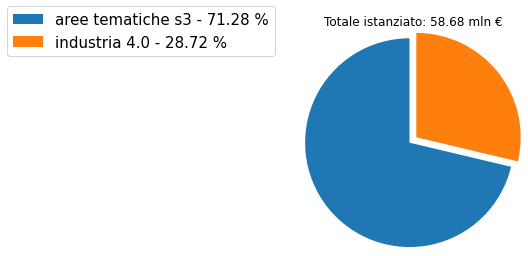

FINANZE PER PROGETTI CON AREA TEMATICA S3



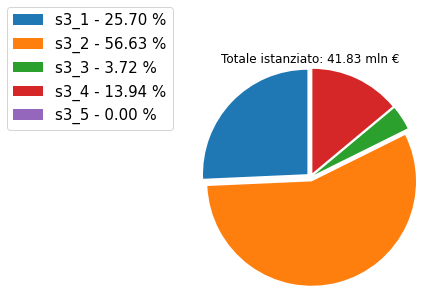

FINANZE PER PROGETTI INDUSTRIA 4.0



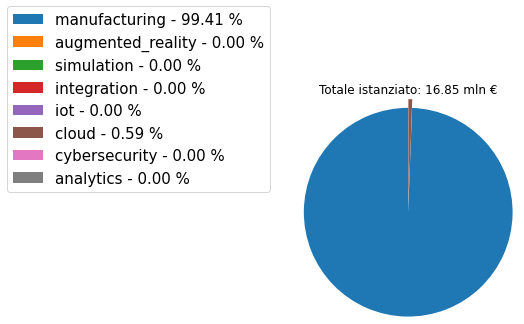

In [ ]:
#tot_list_s3 = pesaro_s3+ancona_s3+macerata_s3+fermo_s3+ascoli_s3
#tot_list_ind4 = pesaro_ind4+ancona_ind4+macerata_ind4+fermo_ind4+ascoli_ind4

tot_list_s3 = np.empty(len(ancona_s3))
for i in range(len(ancona_s3)):
  tot_list_s3[i] = pesaro_s3[i]+ancona_s3[i]+macerata_s3[i]+fermo_s3[i]+ascoli_s3[i]

tot_list_ind4 = np.empty(len(ancona_ind4))
for i in range(len(ancona_ind4)):
  tot_list_ind4[i] = pesaro_ind4[i]+ancona_ind4[i]+macerata_ind4[i]+fermo_ind4[i]+ascoli_ind4[i]

tot, string_val = calc_val_and_str(tot_list_s3,tot_list_ind4)
print("FINANZE PER PROGETTI NELLA REGIONE MARCHE\n")
pieChart(f"Totale istanziato: {tot[-1]} {string_val} €", ["aree tematiche s3", "industria 4.0"], [tot[0], tot[1]], (0.05,0.05))
plt.show()


# tot_list_s3 = list( map(lambda a,b: a+b, pesaro_s3, list(map(lambda a,b: a+b, ancona_s3,list(map(lambda a,b: a+b, macerata_s3,list(map(lambda a,b: a+b, fermo_s3,ascoli_s3))))))) )

tot, string_val = calc_val_and_str(tot_list_s3)
print("FINANZE PER PROGETTI CON AREA TEMATICA S3\n")
pieChart(f"Totale istanziato: {tot[-1]} {string_val} €", list(s3_dict.keys()), tot_list_s3, explode=np.ones(len(tot_list_s3))*0.05)
plt.show()


#tot_list_ind4 = list( map(lambda a,b: a+b, pesaro_ind4,list(map(lambda a,b: a+b, ancona_ind4,list(map(lambda a,b: a+b, macerata_ind4,list(map(lambda a,b: a+b, fermo_ind4,ascoli_ind4))))))) )
tot, string_val = calc_val_and_str(tot_list_ind4)
print("FINANZE PER PROGETTI INDUSTRIA 4.0\n")
pieChart(f"Totale istanziato: {tot[-1]} {string_val} €",list(ind4_dict.keys()), tot_list_ind4, explode=np.ones(len(tot_list_ind4))*0.05)
plt.show()


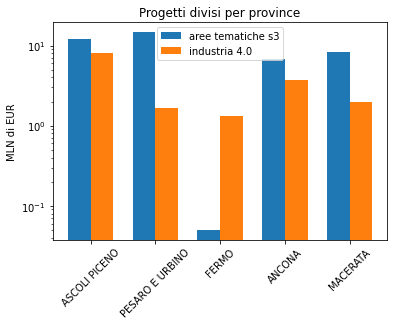

VALORI IN MILIONI DI EURO


ASCOLI PICENO:
	aree tematiche s3: 12.05
	industria 4.0: 8.14

 PESARO E URBINO:
	aree tematiche s3: 14.68
	industria 4.0: 1.6600000000000001

 FERMO:
	aree tematiche s3: 0.05
	industria 4.0: 1.31

 ANCONA:
	aree tematiche s3: 6.8500000000000005
	industria 4.0: 3.7600000000000002

 MACERATA:
	aree tematiche s3: 8.21
	industria 4.0: 2.0




In [ ]:
province = {
    "ASCOLI PICENO": calc_val_and_str(ascoli_s3, ascoli_ind4)[0][0:-1],
    "PESARO E URBINO": calc_val_and_str(pesaro_s3, pesaro_ind4)[0][0:-1],
    "FERMO": calc_val_and_str(fermo_s3, fermo_ind4)[0][0:-1],
    "ANCONA": calc_val_and_str(ancona_s3, ancona_ind4)[0][0:-1],
    "MACERATA": calc_val_and_str(macerata_s3, macerata_ind4)[0][0:-1]
}
        
labels = province.keys()
width = 0.35
x = np.arange(len(labels))  # the label locations
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, [val[0] for val in province.values()], width, label='aree tematiche s3')
rects2 = ax.bar(x + width/2, [val[1] for val in province.values()], width, label='industria 4.0')

ax.set_ylabel('MLN di EUR')
ax.set_yscale('log')
ax.set_title('Progetti divisi per province')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.tick_params(axis='x', rotation=45)
ax.legend()

plt.show()
print("VALORI IN MILIONI DI EURO\n\n")
print(*[f"{prov}:\n\taree tematiche s3: {val[0]}\n\tindustria 4.0: {val[1]}\n\n" for prov, val in province.items()])

## Province
Visualizzazione dei dati divise per province

### ASCOLI PICENO

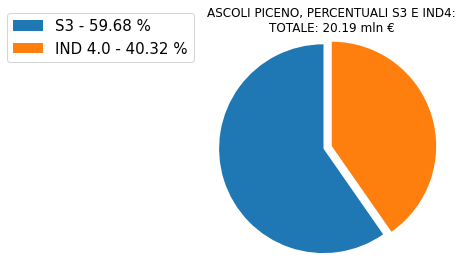

ASCOLI PICENO: FINANZE PER PROGETTI CON AREA TEMATICA S3



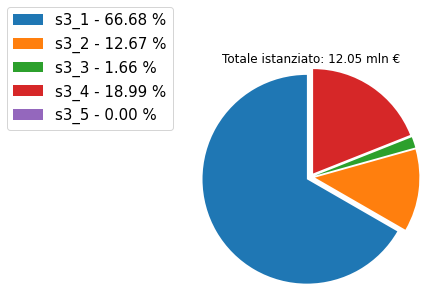

ASCOLI PICENO: FINANZE PER PROGETTI INDUSTRIA 4.0



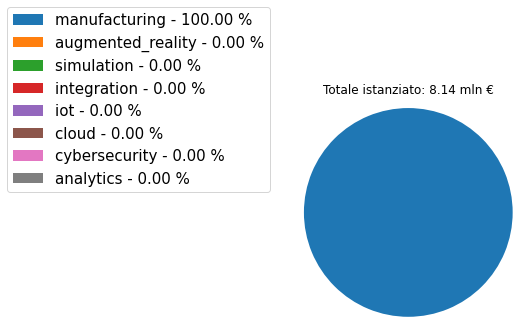

In [ ]:
tot, strin_val = calc_val_and_str(ascoli_s3, ascoli_ind4)
pieChart(f"ASCOLI PICENO, PERCENTUALI S3 E IND4:\nTOTALE: {tot[-1]} {string_val} €", ["S3", "IND 4.0"], [tot[0], tot[1]], (0.1,0))
plt.show()

print("ASCOLI PICENO: FINANZE PER PROGETTI CON AREA TEMATICA S3\n")
tot, string_val = calc_val_and_str(ascoli_s3)
pieChart(f"Totale istanziato: {tot[-1]} {string_val} €",list(s3_dict.keys()), ascoli_s3, np.ones(len(ascoli_s3))*0.05)
plt.show()

print("ASCOLI PICENO: FINANZE PER PROGETTI INDUSTRIA 4.0\n")
tot, string_val = calc_val_and_str(ascoli_ind4)
pieChart(f"Totale istanziato: {tot[-1]} {string_val} €",list(ind4_dict.keys()), ascoli_ind4, explode=np.ones(len(ascoli_ind4))*0.05)
plt.show()

### PESARO E URBINO

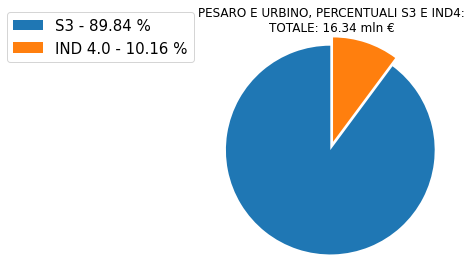

PESARO E URBINO: FINANZE PER PROGETTI CON AREA TEMATICA S3



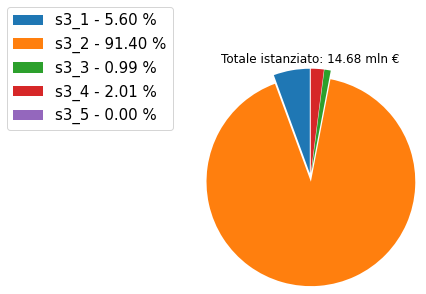

PESARO E URBINO: FINANZE PER PROGETTI INDUSTRIA 4.0



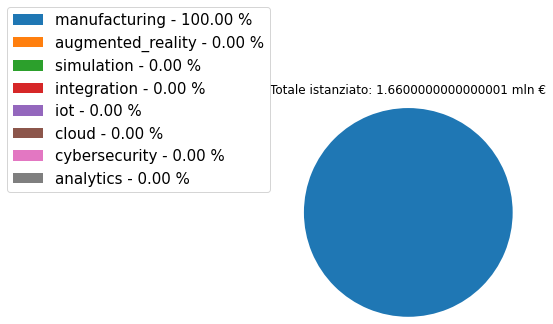

In [ ]:
tot, strin_val = calc_val_and_str(pesaro_s3, pesaro_ind4)
pieChart(f"PESARO E URBINO, PERCENTUALI S3 E IND4:\nTOTALE: {tot[-1]} {string_val} €", ["S3", "IND 4.0"], [tot[0], tot[1]], explode=np.ones(len([tot[0], tot[1]]))*0.05)
plt.show()

tot, strin_val = calc_val_and_str(pesaro_s3)
print("PESARO E URBINO: FINANZE PER PROGETTI CON AREA TEMATICA S3\n")
pieChart(f"Totale istanziato: {tot[-1]} {string_val} €",list(s3_dict.keys()), pesaro_s3, np.ones(len(pesaro_s3))*0.05)
plt.show()

tot, strin_val = calc_val_and_str(pesaro_ind4)
print("PESARO E URBINO: FINANZE PER PROGETTI INDUSTRIA 4.0\n")
pieChart(f"Totale istanziato: {tot[-1]} {string_val} €",list(ind4_dict.keys()), pesaro_ind4, explode=np.ones(len(pesaro_ind4))*0.05)
plt.show()

### FERMO

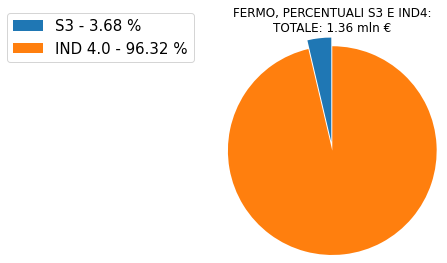

FERMO: FINANZE PER PROGETTI CON AREA TEMATICA S3



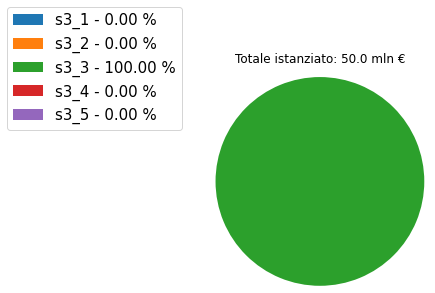

FERMO: FINANZE PER PROGETTI INDUSTRIA 4.0



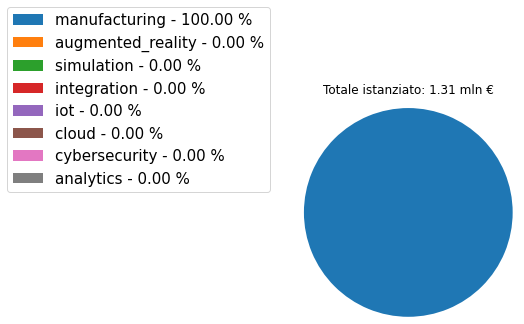

In [ ]:
tot, strin_val = calc_val_and_str(fermo_s3, fermo_ind4)
pieChart(f"FERMO, PERCENTUALI S3 E IND4:\nTOTALE: {tot[-1]} {string_val} €", ["S3", "IND 4.0"], [tot[0], tot[1]], explode=np.ones(len([tot[0], tot[1]]))*0.05)
plt.show()

tot, strin_val = calc_val_and_str(fermo_s3)
print("FERMO: FINANZE PER PROGETTI CON AREA TEMATICA S3\n")
pieChart(f"Totale istanziato: {tot[-1]} {string_val} €",list(s3_dict.keys()), fermo_s3, np.ones(len(fermo_s3))*0.05)
plt.show()


tot, strin_val = calc_val_and_str(fermo_ind4)
print("FERMO: FINANZE PER PROGETTI INDUSTRIA 4.0\n")
pieChart(f"Totale istanziato: {tot[-1]} {string_val} €",list(ind4_dict.keys()), fermo_ind4, explode=np.ones(len(fermo_ind4))*0.05)
plt.show()

### ANCONA

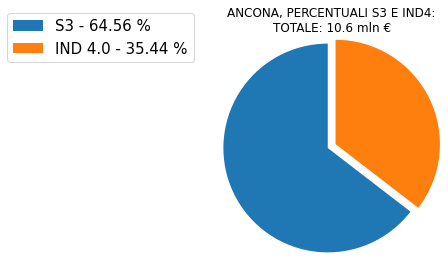

ANCONA: FINANZE PER PROGETTI CON AREA TEMATICA S3



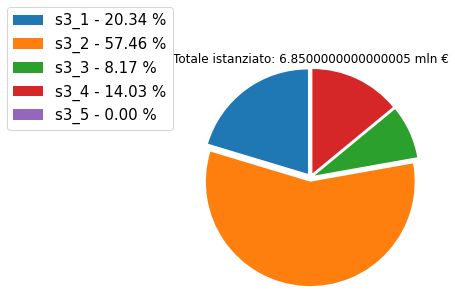

ANCONA: FINANZE PER PROGETTI INDUSTRIA 4.0



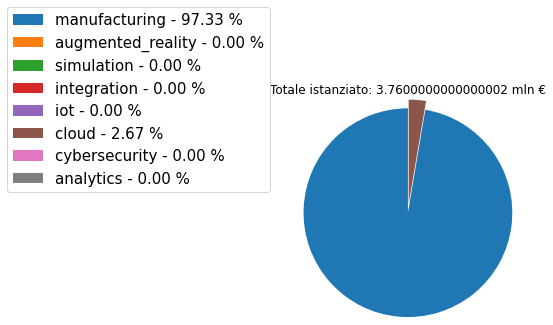

In [ ]:
tot, strin_val = calc_val_and_str(ancona_s3, ancona_ind4)
pieChart(f"ANCONA, PERCENTUALI S3 E IND4:\nTOTALE: {tot[-1]} {string_val} €", ["S3", "IND 4.0"], [tot[0], tot[1]], explode=np.ones(len([tot[0], tot[1]]))*0.05)
plt.show()

tot, strin_val = calc_val_and_str(ancona_s3)
print("ANCONA: FINANZE PER PROGETTI CON AREA TEMATICA S3\n")
pieChart(f"Totale istanziato: {tot[-1]} {string_val} €",list(s3_dict.keys()), ancona_s3, np.ones(len(ancona_s3))*0.05)
plt.show()

tot, strin_val = calc_val_and_str(ancona_ind4)
print("ANCONA: FINANZE PER PROGETTI INDUSTRIA 4.0\n")
pieChart(f"Totale istanziato: {tot[-1]} {string_val} €",list(ind4_dict.keys()), ancona_ind4, explode=np.ones(len(ancona_ind4))*0.05)
plt.show()

### MACERATA

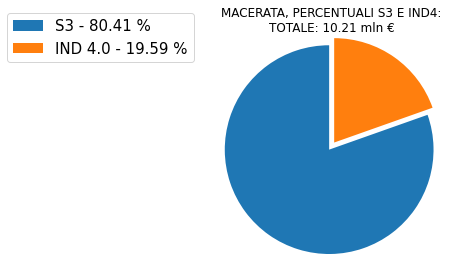

MACERATA: FINANZE PER PROGETTI CON AREA TEMATICA S3



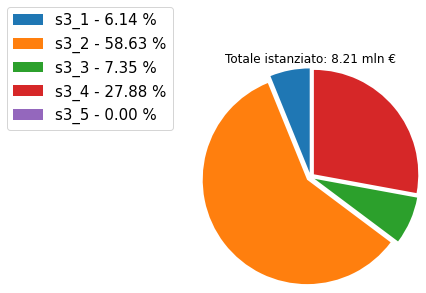

MACERATA: FINANZE PER PROGETTI INDUSTRIA 4.0



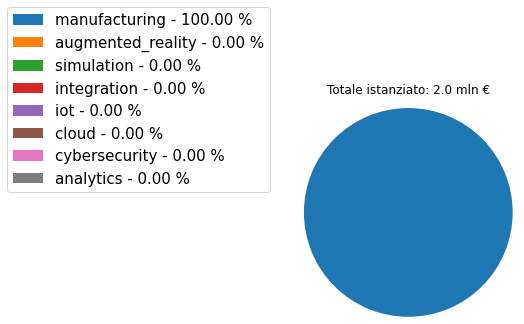

In [ ]:
tot, strin_val = calc_val_and_str(macerata_s3, macerata_ind4)
pieChart(f"MACERATA, PERCENTUALI S3 E IND4:\nTOTALE: {tot[-1]} {string_val} €", ["S3", "IND 4.0"], [tot[0], tot[1]], explode=np.ones(len([tot[0], tot[1]]))*0.05)
plt.show()

tot, strin_val = calc_val_and_str(macerata_s3)
print("MACERATA: FINANZE PER PROGETTI CON AREA TEMATICA S3\n")
pieChart(f"Totale istanziato: {tot[-1]} {string_val} €",list(s3_dict.keys()), macerata_s3, np.ones(len(macerata_s3))*0.05)
plt.show()

tot, strin_val = calc_val_and_str(macerata_ind4)
print("MACERATA: FINANZE PER PROGETTI INDUSTRIA 4.0\n")
pieChart(f"Totale istanziato: {tot[-1]} {string_val} €",list(ind4_dict.keys()), macerata_ind4, explode=np.ones(len(macerata_ind4))*0.05)
plt.show()

# Opzionale!
Salvataggio datasets.

**Nota**: Cambiare i path

In [ ]:

main_path = "output/"
if main_path: # Solo se non vuoto
    try:
        result_dataframe.repartition(1).write.option("header", True).option("delimiter", ";").csv(main_path + "dataset_tot") # Dataset totale
        s3_df.repartition(1).write.option("header", True).option("delimiter", ";").csv(main_path + "dataset_tematiche_s3")   # Dataset dimensioni tematiche s3
        ind4_df.repartition(1).write.option("header", True).option("delimiter", ";").csv(main_path + "dataset_industria_4.0")# Dataset industria 4.0   
    except Exception as e:
        print("C'e' stato un errore nel salvataggio: " + e)
else: print("Aggiungere il path")


'\nmain_path = "output/"\nif main_path: # Solo se non vuoto\n    try:\n        result_dataframe.repartition(1).write.option("header", True).option("delimiter", ";").csv(main_path + "dataset_tot") # Dataset totale\n        s3_df.repartition(1).write.option("header", True).option("delimiter", ";").csv(main_path + "dataset_tematiche_s3")   # Dataset dimensioni tematiche s3\n        ind4_df.repartition(1).write.option("header", True).option("delimiter", ";").csv(main_path + "dataset_industria_4.0")# Dataset industria 4.0   \n    except Exception as e:\n        print("C\'e\' stato un errore nel salvataggio: " + e)\nelse: print("Aggiungere il path")\n'

In [ ]:

main_path = "results/"
!rm -r results
!mkdir results
for key,val in s3_df_dict.items():
   val.repartition(1).write.option("header", True).option("delimiter", ";").csv(main_path + key)
   name_el = list(filter(lambda x: x.startswith("part"), os.listdir(main_path+f"{key}")))[0]
   os.rename(main_path+f"{key}/{name_el}", main_path+f"{key}/{key}.csv")
   



for key,val in ind4_df_dict.items():
   val.repartition(1).write.option("header", True).option("delimiter", ";").csv(main_path + key)
   name_el = list(filter(lambda x: x.startswith("part"), os.listdir(main_path+f"{key}")))[0]
   os.rename(main_path+f"{key}/{name_el}", main_path+f"{key}/{key}.csv")


rm: cannot remove 'results': No such file or directory


#TODO:

* Bisogna calcolare (a mano) la "**precisione**" del filtro come il rapporto del numero di record esatti (nel senso che effettivamente andavano presi) ed il numero di record presi. Si può fare una stima degli stessi prendendo dei campioni a caso.
(Fatto sotto ma da controllare)

* Ottimizzare il tutto evitando di ricalcolare s3_df e ind4_df (si possono ottenere dall'unione dei contenuti in s3_df_dict ed ind4_df_dict che si presuppone siano cachati)



In [ ]:
"""
import random
from IPython.display import clear_output

data = s3_df.union(ind4_df).dropDuplicates().toPandas()
num_righe = data.shape[0]
perc = 2

num_righe_da_controllare = num_righe * perc // 100

indexes_da_controllare = [random.randint(0, num_righe) for _ in range(num_righe_da_controllare)]

counter_buone = 0


for idx in indexes_da_controllare:
    print(idx)
    stringa = data.iloc[idx]["OC_TITOLO_PROGETTO"]
    print("\n\rTITOLO:")
    print(f"\n\r\t{stringa}")
    voto = 1 if input("\n\n\tè buonnna? y/n: ") == "y" else 0
    counter_buone += voto
    clear_output()

precision = counter_buone / num_righe_da_controllare
print(f"\n\n\t\tPrecisione : {precision}")
"""

'\nimport random\nfrom IPython.display import clear_output\n\ndata = s3_df.union(ind4_df).dropDuplicates().toPandas()\nnum_righe = data.shape[0]\nperc = 2\n\nnum_righe_da_controllare = num_righe * perc // 100\n\nindexes_da_controllare = [random.randint(0, num_righe) for _ in range(num_righe_da_controllare)]\n\ncounter_buone = 0\n\n\nfor idx in indexes_da_controllare:\n    print(idx)\n    stringa = data.iloc[idx]["OC_TITOLO_PROGETTO"]\n    print("\n\rTITOLO:")\n    print(f"\n\r\t{stringa}")\n    voto = 1 if input("\n\n\tè buonnna? y/n: ") == "y" else 0\n    counter_buone += voto\n    clear_output()\n\nprecision = counter_buone / num_righe_da_controllare\nprint(f"\n\n\t\tPrecisione : {precision}")\n'

In [ ]:
!zip -r results.zip results

  adding: results/ (stored 0%)
  adding: results/s3_5/ (stored 0%)
  adding: results/s3_5/._SUCCESS.crc (stored 0%)
  adding: results/s3_5/_SUCCESS (stored 0%)
  adding: results/s3_5/.part-00000-3706b034-f338-49c0-8bcf-3a123a2f861a-c000.csv.crc (stored 0%)
  adding: results/s3_5/s3_5.csv (deflated 48%)
  adding: results/manufacturing/ (stored 0%)
  adding: results/manufacturing/._SUCCESS.crc (stored 0%)
  adding: results/manufacturing/_SUCCESS (stored 0%)
  adding: results/manufacturing/.part-00000-6ac25783-6c34-46d2-ad4d-a750b7299356-c000.csv.crc (stored 0%)
  adding: results/manufacturing/manufacturing.csv (deflated 93%)
  adding: results/s3_4/ (stored 0%)
  adding: results/s3_4/._SUCCESS.crc (stored 0%)
  adding: results/s3_4/_SUCCESS (stored 0%)
  adding: results/s3_4/.part-00000-33b418bc-bcbf-40d3-b817-cd047676842e-c000.csv.crc (stored 0%)
  adding: results/s3_4/s3_4.csv (deflated 77%)
  adding: results/s3_2/ (stored 0%)
  adding: results/s3_2/._SUCCESS.crc (stored 0%)
  adding: r

In [ ]:
result_dataframe.where("COD_LOCALE_PROGETTO = '4MISEF/200043/02/X45'").toPandas().to_dict('records')

[{'COD_LOCALE_PROGETTO': '4MISEF/200043/02/X45',
  'CUP_DESCR_CATEGORIA': 'ALTRE AREE TECNOLOGICHE',
  'CUP_DESCR_NATURA': "CONCESSIONE DI INCENTIVI AD UNITA' PRODUTTIVE",
  'CUP_DESCR_SETTORE': 'RICERCA SVILUPPO TECNOLOGICO ED INNOVAZIONE',
  'CUP_DESCR_SOTTOSETTORE': 'PROGETTI DI RICERCA E  DI INNOVAZIONE PRESSO IMPRESE',
  'CUP_DESCR_TIPOLOGIA': "Attivita' di ricerca",
  'DEN_COMUNE': 'Camerino',
  'DEN_PROVINCIA': 'MACERATA',
  'DEN_REGIONE': 'MARCHE',
  'DESCRIZIONE_GRANDE_PROGETTO': ' ',
  'FINANZ_TOTALE_PUBBLICO': 461145.6,
  'INDIRIZZO_PROG': 'LoacalitÃ\x83Â\xa0 Torre del Parco snc',
  'OC_DATA_INIZIO_PROGETTO': '20190901',
  'OC_SINTESI_PROGETTO': 'BIOTECNOLOGIE',
  'OC_TITOLO_PROGETTO': 'PROBIOTIC NUTRACEUTICAL FOODS: RICERCA E SVILUPPO DI NUOVI ALIMENTI FUNZIONALI DI TIPO DOLCIARIO AD AZIONE PROBIOTICA'}]